# SuStaIn tutorial using simulated data

Written by Alex Young in April 2020, updated in April 2021. Please email alexandra.young@kcl.ac.uk with any questions.

This tutorial demonstrates how to run Subtype and Stage Inference (SuStaIn) using simulated data. SuStaIn is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. In this tutorial I use the linear z-score model I used in [Young et al. 2018](https://doi.org/10.1038/s41467-018-05892-0), but it is possible to use other models of biomarker evolution, such as the event-based model.

For a demonstration of the 'event-based'/mixture modelling version of SuStaIn (i.e. MixtureSustain), see simrun.py, available in the /sim subdirectory of the pySuStaIn package.

## Installing SuStaIn and setting it up to run in a notebook

To get SuStaIn up and running first you need to install the package. I'm using Anaconda and had some conflicts with existing packagaes so I had to create a new environment and set it up to be accessible from a jupyter notebook. For me the whole set up process looked like this...

Step 1: Create a new environment "sustain_env" in anaconda that uses python 3.7 and activate the environment ready to install pySuStaIn.
```console
conda create --name sustain_env python=3.7
conda activate sustain_env
```

Step 2: Install pySuStaIn within the environment. The first line installs the kde-ebm (not needed for this tutorial), and the second line installs pySutaIn. Using the -e option enables you to edit the code (most users won't need to do this so can remove the -e). 
```console
pip install -e ./awkde
pip install -e .
```

Step 3: To get the new environment to run inside a notebook I had to install ipykernel and use that to add the environment as a new kernel.
```console
conda install ipykernel
python3.7 -m ipykernel install --user --name sustain_env
```

When running the notebook you then need to make sure you're using the new kernel (it should appear as sustain_env in the top right hand corner, or you need to select it using Kernel>Change kernel>sustain_env).

## Importing packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import sklearn.model_selection
import pandas as pd
import pylab
import sys
import pySuStaIn
import scipy.io as scio  

#sys.path.insert(0,'../sim/')
#from simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

D:\anaconda3\envs\pysustain\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The SuStaIn algorithm

SuStaIn identifies subtypes with distinct progression patterns from cross-sectional data. The algorithm proceeds hierarchically, first fitting a single subtype to the data, then two, then three, etc., up to a maximum number of subtypes chosen by the user. The fitting of the nth subtype model works but splitting each of the previous n-1 clusters into two and then using this as an initialisation to fit the n subtype model. For each of the n subtype models, SuStaIn uses MCMC sampling to estimate the uncertainty in the subtype progression patterns and the proportion of individuals that belong to each subtype. The optimal number of subtypes is selected by using cross-validation to compute the cross-validation information criterion (CVIC).

In [2]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

path = r'G:\Sustain_P1\sustain\notebook\NMH\AllChort\AllSubjects.xls'  # 参数初始化
data = pd.read_excel(path)  # 读取数据
print(data.describe())
data = data.values
path


       Biomarker01  Biomarker02  Biomarker03  Biomarker04  Biomarker05  \
count  1124.000000  1124.000000  1124.000000  1124.000000  1124.000000   
mean      0.549962     0.381839     0.463029     0.104135    -0.047454   
std       1.133896     1.046981     1.083461     1.124697     1.099264   
min      -4.065935    -3.225626    -3.402469    -4.097481    -5.008794   
25%      -0.197133    -0.296861    -0.215711    -0.610040    -0.759085   
50%       0.512588     0.346741     0.438623     0.174500    -0.007102   
75%       1.229921     0.966190     1.085949     0.837144     0.663175   
max       5.256533     6.978979     5.064343     4.928275     5.148857   

       Biomarker06  Biomarker07  Biomarker08  Biomarker09  Biomarker10  \
count  1124.000000  1124.000000  1124.000000  1124.000000  1124.000000   
mean     -0.447695     0.336785     0.234207     0.430988     0.440162   
std       1.198744     1.113593     1.160092     1.075091     1.104061   
min      -8.031238    -3.818622    -4

'G:\\Sustain_P1\\sustain\\notebook\\NMH\\AllChort\\AllSubjects.xls'

In [3]:
# Input the settings for z-score SuStaIn
M       = 1124       # number of subjects
N       = 17         # number of biomarkers
N_S_max = 6         # number of subtypes

N_startpoints = 25                  # usually N_startpoints = 25
N_iterations_MCMC = int(1e5)        # usually N_iterations_MCMC = int(1e5) or int(1e6)

output_folder = os.path.join(os.getcwd(), 'scz1124')
dataset_name = 'scz1124'

SuStaInLabels           = []
for i in range(N):
        SuStaInLabels.append( 'Biomarker '+str(i)) # labels of biomarkers for plotting
        
Z_vals                  = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max                   = np.array([5]*N)           # maximum z-score

# To demonstrate how to set different biomarkers to have different z-scores,
# set biomarker 0 to have z-scores of 1 and 2 only and a maximum of 3
# to do this change the corresponding row of Z_vals to read 1 2 0
# and change the corresponding row of Z_max to 3
# Z_vals[np.array(0),np.array(2)] = 0
# Z_max[np.array(0)] = 3

# and set biomarker 2 to have a z-score of 1 only and a maximum of 2
# to do this change the corresponding row of Z_vals to read 1 0 0 
# and change the corresponding row of Z_max to 2 
# Z_vals[np.array(2),np.array([1,2])] = 0
# Z_max[np.array(2)] = 2

use_parallel_startpoints = True  # use_parallel_startpoints    - boolean for whether or not to parallelize the maximum likelihood loop

sustain_input = pySuStaIn.ZscoreSustain(data,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              use_parallel_startpoints)

## Create folder for results if it doesn't exist already

In [4]:
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

## Running the SuStaIn algorithm

We're finally ready to run the SuStaIn algorithm! The main outputs are samples_sequence and samples_f. samples_sequence gives MCMC samples of the ordering of the biomarker z-scores for each n subtype model. samples_f gives MCMC samples of the proportion of individuals that belong to each subtype for each n subtype model. These can be found in the outputted files.

In [5]:
# runs the sustain algorithm with the inputs set in sustain_input above
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype3.pickle. Using pickled variables for 3 subtype.
Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype4.pickle. Using pickled variables for 4 subtype.
Found pickle file: G:\Sustain_P1\sustain\notebook\NMH\AllChort\scz1124\pickle_files\scz1124_subtype5.pickle. Using pickled variables for 5 subtype.


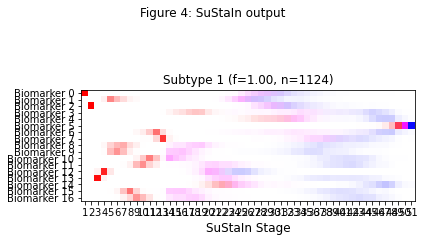

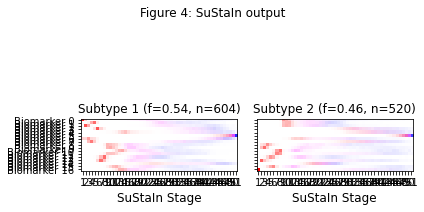

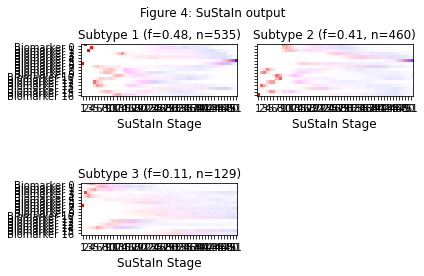

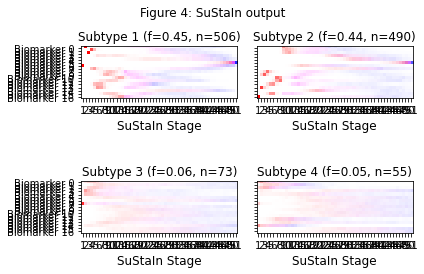

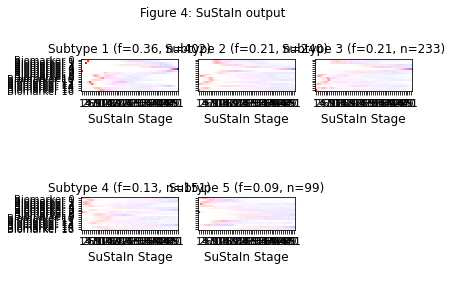

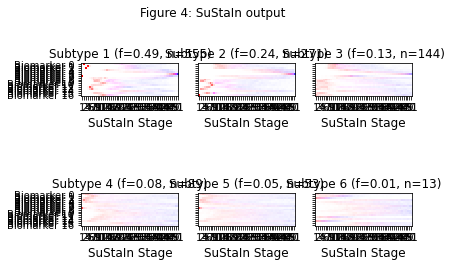

In [8]:
for s in range(N_S_max):
    pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pickle_filepath             = Path(pickle_filename_s)
    pickle_file                 = open(pickle_filename_s, 'rb')
    loaded_variables            = pickle.load(pickle_file)
    ml_subtype                  = loaded_variables["ml_subtype"]
    prob_ml_subtype             = loaded_variables["prob_ml_subtype"]
    ml_stage                    = loaded_variables["ml_stage"]
    prob_ml_stage               = loaded_variables["prob_ml_stage"]
    prob_subtype                = loaded_variables["prob_subtype"]
    prob_stage                  = loaded_variables["prob_stage"]
    prob_subtype_stage          = loaded_variables["prob_subtype_stage"]
    ml_sequence_EM              = loaded_variables["ml_sequence_EM"]
    samples_sequence            = loaded_variables["samples_sequence"]
    samples_f                   = loaded_variables["samples_f"]
    pickle_file.close()  
    
    subtype_folder = output_folder + '/subtype' + str(s+1)
    
    if not os.path.isdir(subtype_folder):
        os.mkdir(subtype_folder) 
        
    # save the MCMC results in Matlab .mat
    matlab_output = os.path.join(subtype_folder, 'samples_sequence.mat')
    scio.savemat(matlab_output, {'samples_sequence':samples_sequence,'samples_f':samples_f})
    inputdata_subj_ids   = list(np.arange(1, M+1).astype('str'))
    
    df                      = pd.DataFrame()
    df['subj_id']           = inputdata_subj_ids
    df['ml_subtype']        = ml_subtype
    df['prob_ml_subtype']   = prob_ml_subtype
    df['ml_stage']          = ml_stage
    df['prob_ml_stage']     = prob_ml_stage
    df.to_csv(os.path.join(subtype_folder, 'Subject_subtype_stage_estimates.csv'), index=False)
    df2                      = pd.DataFrame(ml_sequence_EM)
    df2.to_csv(os.path.join(subtype_folder, 'ml_sequence_EM.csv'), index=False) 
    FONT_SIZE               = 8
    
    # The code below plots the output
    pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M)
    _ = plt.suptitle('Figure 4: SuStaIn output')
    
    plt.savefig(os.path.join(subtype_folder, 'Figure4-SuStaIn output.png'),dpi=600)



# You can also subtype and stage new data using
# N_samples                       = 1000
# ml_subtype,                  \
# prob_ml_subtype,             \
# ml_stage,                    \
# prob_ml_stage,               \
# prob_subtype,                \
# prob_stage,                  \
# prob_subtype_stage          = sustain_input.subtype_and_stage_individuals_newData(new_data,
#                                                                                   samples_sequence,
#                                                                                   samples_f,
#                                                                                   N_samples)